In [10]:
!pip install langchain_core transformers runhouse

  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached pynvml-12.0.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached virtualenv-20.28.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached nvidia_ml_py-12.560.30-py3-none-any.whl.metadata (8.6 kB)
  Using cached distlib-0.3.9-py2.py3-none-any.whl.metadata (5.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.5/340.5 kB 3.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Using cached setuptools-69.5.1-py3-none-any.whl (894 kB)
Using cached async_timeout-5.0.1-py3-none-any.whl (6.2 kB)
Using cached pynvml-12.0.0-py3-none-any.whl (26 kB)
Using cached nvidia_ml_py-12.560.30-py3-none-any.whl (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 5.3 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached virtualenv-20.28.0-py3-none-any.whl (4.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [16]:
import os

os.environ["ANTHROPIC_API_KEY"] = "sk-ant-"
os.environ["OPENAI_API_KEY"] = "sk-"

In [17]:
from langchain_openai import OpenAIEmbeddings


embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    # With the `text-embedding-3` class
    # of models, you can specify the size
    # of the embeddings you want returned.
    # dimensions=1024
)

In [22]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph, END
from typing_extensions import List, TypedDict
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings


# RAG definition
vector_store = InMemoryVectorStore(embeddings)

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}




/home/amor/anaconda3/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [23]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

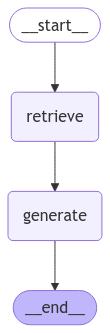

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"question": user_input}):
        print(event)
        print("Assistant:", event["answer"])


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  agents


{'retrieve': {'context': [Document(id='8662e1a7-25d9-427b-95dd-f237ffc9cf59', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.\nGenerative Agents Simulation#\nGenerative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.\nThe design of generative

KeyError: 'answer'